In [113]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image 
from tensorflow.keras import layers

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [82]:
path = Path.cwd()/'data'
answers = pd.read_csv(path/'train.csv')
images_directory = path/'train_images'

In [97]:
def get_image_path(row):
    file_name = (row['name']+'.jpg')
    if row['label']==0:
        return images_directory/'no_whale'/file_name
    else:
        return images_directory/'whale'/file_name
    
        

In [136]:
answers['name'] = answers['clip_name'].str.split('.').str[0]
answers['clip_path']=path/'train'/answers['clip_name']
answers['image_path']=answers.apply(get_image_path, axis=1)
answers.head()
answers.to_csv('answers.csv')

<AxesSubplot:xlabel='label', ylabel='Count'>

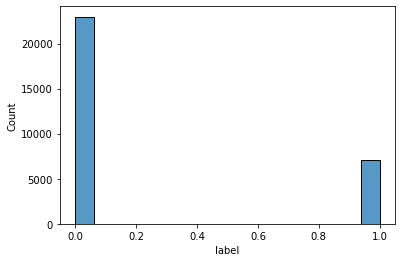

In [9]:
sns.histplot(data=answers, x='label')
# So we've got >20K no right whales, and 5K right whales examples. 

# Processing Sound Data
* Dont load the entire dataset into memory. There are 30K sound files in there - small ones, but still

* Load in 
* Turn into mel spectrogram
* Sampling rate is the same for everything - 2000
* Length is the same as well - 2 seconds (which we then stretch) 
* Since the sound is already cut into batches, and they all start pretty consistenly at the start, we don't need to time shift 

## Questions
Two major ones I can think of: 
* Do we want to resample? We can later, but lets start with no
* Should we mask frequencies? Since we're keeping it at the base 2000, we don't need to mask frequencies 

## How many files
* Lets start with 5 so my laptop doesnt die 



In [15]:
which_file = 6
filename1 = f'''train{which_file}.aiff'''
filename1
y, sr = librosa.load('data/train/'+filename1,sr=None)
# sr=2000

# y = librosa.resample(y0, orig_sr=sr0, target_sr=sr)
#Specifying the sampling rate explicitly, since this is given 
print(y.shape)
print(sr)

(4000,)
2000


In [75]:
def read_sound(index, df):
    row = df.iloc[index]
    clip_path = row['clip_path']
    image_path = row['image_path']
    y, sr = librosa.load(clip_path, sr=None)
    del clip_path, row
    return y, sr, image_path 

def create_spectrogram(input_tuple):
    y, sr, output_file = input_tuple
    fig = plt.figure(figsize=[0.72, 0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    spec = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(spec, ref=np.max))
    plt.savefig(output_file, dpi=400, bbox_inches='tight', pad_inches=0)
    plt.close()
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del spec, fig, ax, y, sr, output_file, input_tuple
    
    

In [68]:
create_spectrogram(read_sound(5))

In [100]:
sample = pd.concat([answers[answers['label']==0].sample(3, random_state=1),answers[answers['label']==1].sample(3, random_state=1)])
sample.head(6)

,clip_name,label,name,clip_path,image_path
10239,train10240.aiff,0,train10240,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
9519,train9520.aiff,0,train9520,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
12749,train12750.aiff,0,train12750,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
29781,train29782.aiff,1,train29782,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
26564,train26565.aiff,1,train26565,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...
25236,train25237.aiff,1,train25237,/Users/mariapolyakova/Documents/metis/deep/rig...,/Users/mariapolyakova/Documents/metis/deep/rig...


In [101]:
from tqdm import tqdm

for i in tqdm(range(0, sample.shape[0])):
    create_spectrogram(read_sound(i, sample))


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 16.74it/s]


In [77]:
image_path = sample.iloc[4]['image_path']

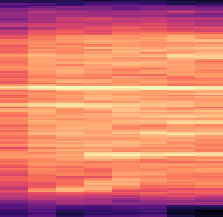

In [78]:
image.load_img(image_path)

In [116]:
sample = image_dataset_from_directory(images_directory, labels='inferred', image_size=(64,64))

Found 6 files belonging to 2 classes.


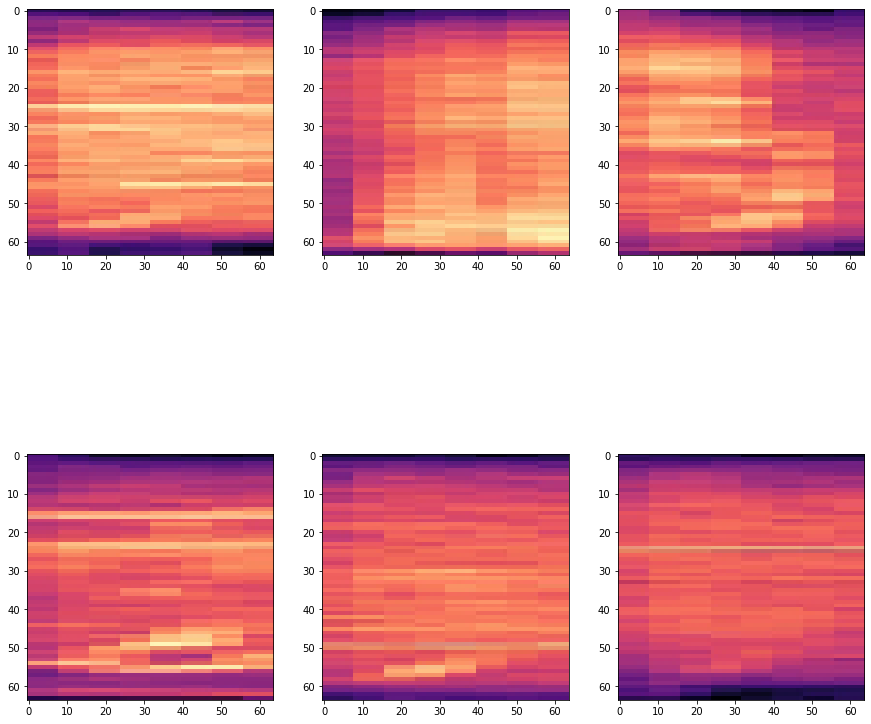

In [117]:
fig, axes = plt.subplots(2,3, figsize=(15,15))
for images, labels in sample.take(1):
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype('uint8'))

In [112]:
for images, labels in sample.take(1):
    print(images)
    print(images.shape)

tf.Tensor(
[[[[ 36.         10.         83.       ]
   [ 36.         10.         83.       ]
   [ 36.         10.         83.       ]
   ...
   [ 16.         10.         46.       ]
   [ 16.         10.         46.       ]
   [ 16.         10.         46.       ]]

  [[ 44.48633    16.94336    93.0293   ]
   [ 44.48633    16.94336    91.784676 ]
   [ 44.48633    16.94336    92.53205  ]
   ...
   [ 14.457031    8.457031   44.45703  ]
   [ 14.457031    8.457031   44.45703  ]
   [ 14.457031    8.457031   44.45703  ]]

  [[ 50.095703   18.38086   100.953125 ]
   [ 50.095703   18.38086    99.33984  ]
   [ 50.095703   18.38086   100.30859  ]
   ...
   [ 14.619141    8.619141   45.85742  ]
   [ 14.619141    8.619141   45.85742  ]
   [ 14.619141    8.619141   45.85742  ]]

  ...

  [[ 60.384766   19.621094   96.765625 ]
   [ 60.384766   19.621094   96.765625 ]
   [ 60.384766   19.621094   96.765625 ]
   ...
   [ 42.429688   17.695004   88.42249  ]
   [ 42.429688   17.879482   88.053535 ]
   [ 

In [118]:
model = keras.Sequential()

model.add(layers.InputLayer(input_shape=(64,64, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1228900   
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 1,249,201
Trainable params: 1,249,201
Non-trainable params: 0
_________________________________________________________________


In [120]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [123]:
history = model.fit(sample, epochs=2) # Woooot random guessing!

Epoch 1/2
1/1 [==============================] - 0s 13ms/step - loss: 626.7288 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 13ms/step - loss: 118.2690 - accuracy: 0.5000


 # A Brief Pause: 
    Now that I've performed this on a sample, lets perform this on the full set
    

In [124]:
import gc
for i in tqdm(range(0, answers.shape[0])):
    create_spectrogram(read_sound(i, answers))
    if(i%2000 == 0):
        gc.collect()
        

100%|█████████████████████████████████████| 30000/30000 [28:08<00:00, 17.77it/s]


In [134]:
cb_training = image_dataset_from_directory(images_directory, labels='inferred', image_size=(64,64), subset='training', validation_split=.2, seed=10)
cb_validation = image_dataset_from_directory(images_directory, labels='inferred', image_size=(64,64), subset='validation', validation_split=.2, seed=10)

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.


In [131]:
model = keras.Sequential()

model.add(layers.InputLayer(input_shape=(64,64, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               1228900   
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 1,249,201
Trainable params: 1,249,201
Non-trainable params: 0
_________________________________________________________________


In [132]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [135]:
history = model.fit(cb_training, epochs=2,validation_data=cb_validation) 

Epoch 1/2
750/750 [==============================] - 11s 14ms/step - loss: 14.3396 - accuracy: 0.7519 - val_loss: 0.3792 - val_accuracy: 0.8222
Epoch 2/2
750/750 [==============================] - 10s 13ms/step - loss: 0.3616 - accuracy: 0.8248 - val_loss: 0.3586 - val_accuracy: 0.7677
